# Workshop 5 – Vector Data Fundamentals in Python  
**Programación SIG**   
2025-1
Lecturer: Liliana Castillo Villamor

## 1. Learning objectives  
After completing this workshop you will be able to  

1. Describe `GeoDataFrame`, `GeoSeries`, and **Shapely** geometries.  
2. Inspect, measure, and transform vector data in a metric CRS.  
3. Manipulate attributes with pandas/GeoPandas (selection, aggregation, joins).  
4. Join a non‑spatial agricultural table to a spatial layer.  
5. Dissolve polygons to summarise at regional level.  
6. Produce publication‑ready maps in Python.

*All text uses British English spelling.*  


---

## 2.  Setting the scene

### 2.1. **Import** the core libraries.

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from pathlib import Path

### 2.2. Define data paths, and read the municipal shapefile and agricultural CSV.


| Step | What happens? | Key function / property |
|------|---------------|-------------------------|
| **1&nbsp;️&nbsp;Define `root_folder`** | Sets a *base directory* that stores all the workshop material on your computer. Change this string if your files live elsewhere. | *Plain Python string* |
| **2&nbsp;️&nbsp;Build file paths** – `shp_path`, `csv_path` | Concatenates the base directory with each filename. The **raw-string prefix `r"…"``** avoids back-slash issues under Windows. | String concatenation |
| **3&nbsp;️&nbsp;Read the shapefile** – `df_municipios = gpd.read_file(shp_path)` | Loads **`municipios_colombia.shp`** (plus its `.dbf`, `.shx`, `.prj` companions) into a GeoDataFrame. | `geopandas.read_file()` |
| **4&nbsp;️&nbsp;Create a second GeoDataFrame `muni`** | Re-opens the same shapefile so we can keep an untouched copy or experiment independently. | `geopandas.read_file()` |
| **5&nbsp;️&nbsp;Print the CRS** – `print("CRS:", muni.crs)` | Confirms the layer’s Coordinate Reference System. It should report **EPSG 3116 – MAGNA-SIRGAS / Colombia Bogotá** (units: metres). | `GeoDataFrame.crs` |
| **6&nbsp;️&nbsp;Inspect the schema** – `muni.info()` | Shows a tidy summary: number of rows, data types, and non-null counts for every column. Useful for quick QA. | `GeoDataFrame.info()` |
| **7&nbsp&nbsp;Preview the first rows** – `muni.head()` | Prints the first five records so you can spot-check attribute names and typical values. | `GeoDataFrame.head()` |

> **Note:** The path for the EVA table (`csv_path`) is defined here but **not** read yet—we will load it later when demonstrating attribute joins.

If you encounter “file not found” errors, double-check that **`root_folder`** reflects the actual folder structure on *your* machine and that filenames (including capitalisation) are correct.

In [96]:
root_folder=r"C:\Users/Liliana/OneDrive - Universidad Nacional de Colombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"
root_folder=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"

shp_path=root_folder+r"/municipios_colombia.shp"
df_municipios = gpd.read_file(shp_path)
csv_path  = root_folder+"/Evaluaciones_Agropecuarias_Municipales_EVA.csv"
stations_csv_path=root_folder+"/Catalogo_Estaciones_IDEAM.csv"
muni = gpd.read_file(shp_path)
print("CRS:", muni.crs)              
muni.info()
print(muni.head())

CRS: EPSG:3116
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 92 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DPTO_CCDGO  1122 non-null   object  
 1   MPIO_CCDGO  1122 non-null   object  
 2   MPIO_CNMBR  1122 non-null   object  
 3   MPIO_CDPMP  1122 non-null   object  
 4   VERSION     1122 non-null   int32   
 5   AREA        1122 non-null   float64 
 6   LATITUD     1122 non-null   float64 
 7   LONGITUD    1122 non-null   float64 
 8   STCTNENCUE  1122 non-null   float64 
 9   STP3_1_SI   1122 non-null   float64 
 10  STP3_2_NO   1122 non-null   float64 
 11  STP3A_RI    1122 non-null   float64 
 12  STP3B_TCN   1122 non-null   float64 
 13  STP4_1_SI   1122 non-null   float64 
 14  STP4_2_NO   1122 non-null   float64 
 15  STP9_1_USO  1122 non-null   float64 
 16  STP9_2_USO  1122 non-null   float64 
 17  STP9_3_USO  1122 non-null   float64 
 18  STP9_4_USO  1122 non-null

The municipality layer follows the Marco Geoestadístico Nacional – MGN 2018 schema published by DANE.
A full description of every attribute appears in the official manual “MGN 2018 integrado con CNPV 2018 – Instructivo de Uso” (DANE 2020). You can find the document in the course data folder. The file is called "MGN2018_Integrado_CNPV2018_InstructivoUso.pdf".



## 3  GeoDataFrame anatomy  

`muni` is a **GeoDataFrame** – essentially a pandas DataFrame plus a special *geometry* column (a **GeoSeries**) containing Shapely objects. The next cell inspects their classes and geometry types.


A **GeoSeries** is the spatial cousin of a pandas *Series*: a one-dimensional array whose elements are **Shapely** geometry objects (e.g. `Point`, `LineString`, `Polygon`).  
Each geometry can be written or read as **WKT** (*Well-Known Text*), a plain-text OGC standard such as `POINT (-74.08 4.60)`; Shapely converts seamlessly between WKT strings and live objects.

A **GeoDataFrame** extends a pandas *DataFrame* by declaring one special column—usually called `geometry`—to hold that GeoSeries of Shapely objects and by storing a `crs` attribute for the Coordinate Reference System.  
Because it “knows” which column is spatial, a GeoDataFrame unlocks GeoPandas functionality: mapping, reprojection, spatial joins, overlays, and more, while all other columns behave exactly like a regular DataFrame.

&nbsp;&nbsp;⇒ *DataFrame* = purely tabular.  
&nbsp;&nbsp;⇒ *GeoDataFrame* = tabular **plus** spatial context (geometry + CRS).

</div>
<div style="border-left:6px solid #20B2AA; padding:12px 16px; background:#f5fffa; border-radius:4px; font-size:95%;">

#### 🌐 What about the CRS?

A **GeoDataFrame** does **not** store its Coordinate Reference System as a separate column.  
Instead, the CRS lives in the object’s **`crs` attribute**, shared by every geometry in the `geometry` column.

* **`gdf.crs`** — returns (or prints) the current CRS, expressed either as an EPSG code or full PROJ string.  
* **`gdf.set_crs(<EPSG>, inplace=True)`** — assigns a CRS *when your data have none*, *without* altering coordinate values.  
* **`gdf.to_crs(<EPSG>)`** — re-projects the coordinates to a new CRS and returns a **new copy**; the original GeoDataFrame remains unchanged.



In [9]:
print(type(muni))
print(type(muni.geometry))
print(type(muni.geometry.iloc[0]))
muni.geom_type.unique()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
<class 'shapely.geometry.polygon.Polygon'>


array(['Polygon', 'MultiPolygon'], dtype=object)

### 3.1  Geometric attributes  

Because our CRS is metric, area and length are returned in square metres and metres.  

The municipal layer is already in **EPSG 3116**, a projected CRS whose linear unit is **metres**.  
That means:

* `muni.area` returns polygon area in **square metres**.  
* `muni.length` returns perimeter in **metres**.

In the next code cell we:

1. Convert area from m² to km² by dividing by `1 000 000` (`1e6`).  
2. Convert perimeter from m to km by dividing by `1 000` (`1e3`).  
3. Attach both derived measures as new columns (`area_km2`, `perim_km`).  

In [11]:
muni['area_km2'] = muni.area / 1e6
muni['perim_km'] = muni.length / 1e3
muni[['MPIO_CNMBR', 'area_km2', 'perim_km']].head()

,MPIO_CNMBR,area_km2,perim_km
0,FLORENCIA,2547.637532,326.343754
1,ALBANIA,414.122070,123.504054
2,BELÉN DE LOS ANDAQUÍES,1191.618572,247.957246
3,EL DONCELLO,1106.076151,349.761349
4,EL PAUJÍL,1234.734145,391.289839


### 3.1.1. Population density

The 2018 census variable **`STP27_PERS`** records the total number of inhabitants in each municipality.  
Dividing this figure by the municipal area in square kilometres (`area_km2`) yields **population density** expressed in *persons km⁻²*.

In the next code cell we:

1. Create a new column, `pop_density_p_km2`, with the formula  
   `STP27_PERS ÷ area_km2`.  
2. Extract a tidy two-column view—`MPIO_CNMBR` (municipality name) and the new density measure—so that we can inspect the first few results at a glance.

In [13]:
muni['pop_density_p_km2'] = muni['STP27_PERS'] / muni['area_km2']


muni_subset = muni[['MPIO_CNMBR', 'pop_density_p_km2']]

# Vista rápida de las primeras filas
muni_subset.head()


,MPIO_CNMBR,pop_density_p_km2
0,FLORENCIA,61.542899
1,ALBANIA,10.900168
2,BELÉN DE LOS ANDAQUÍES,7.615692
3,EL DONCELLO,16.070322
4,EL PAUJÍL,10.539921


### 3.2  First glimpse if spatial data 


### 3.1. Visualising the Most Populous Municipalities

In the following cell,you will identify and visualise the 20 most populous municipalities using the 2018 census data. The population figures are stored in the `STP27_PERS` column of the `muni` DataFrame.

1. First, we ensure that the population values are numeric. This is crucial because non-numeric entries (e.g., missing or malformed data) may cause errors during sorting or plotting. Any invalid entries are safely converted to `NaN` using `errors='coerce'`.

2.  We select two columns—`MPIO_CNMBR` (municipality name) and `STP27_PERS` (population)—and sort the DataFrame in descending order by population. We retain only the top 20 entries.

3.  We generate a horizontal bar chart to make it easier to compare population sizes visually. The chart is sorted from the smallest to the largest (bottom to top), which improves readability.

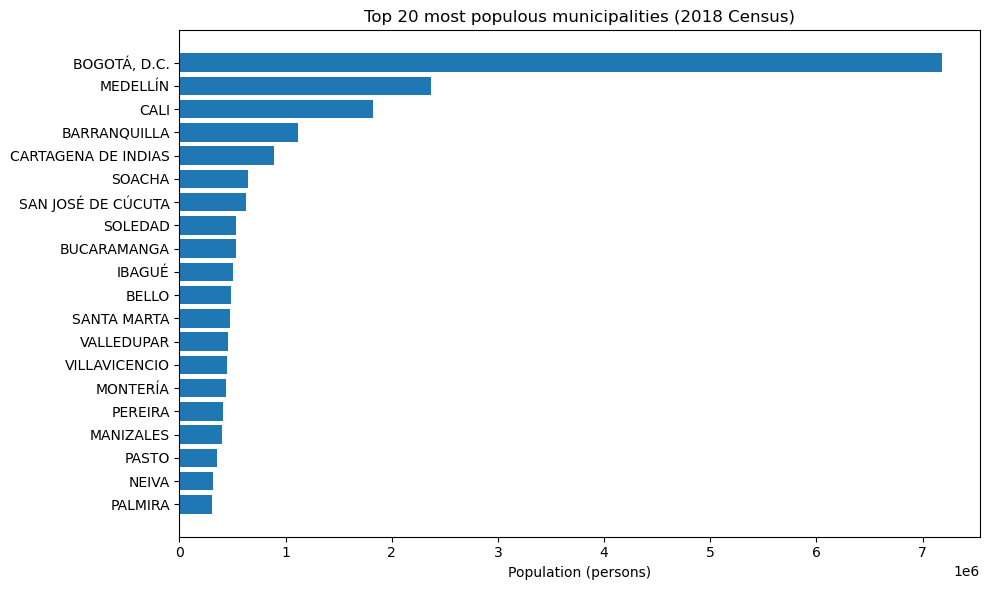

In [16]:
# Make sure the population field is numeric
muni['STP27_PERS'] = pd.to_numeric(muni['STP27_PERS'], errors='coerce')

# Select the 20 largest municipalities by population
top_pop = muni[['MPIO_CNMBR', 'STP27_PERS']]\
            .sort_values('STP27_PERS', ascending=False)\
            .head(20)

# Horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_pop['MPIO_CNMBR'][::-1], top_pop['STP27_PERS'][::-1])
ax.set_xlabel('Population (persons)')
ax.set_title('Top 20 most populous municipalities (2018 Census)')
plt.tight_layout()
plt.show()



#### 🔄 Now it’s your turn – Tabular visualisation practice

Using the same *muni* GeoDataFrame, experiment with the skills you have just seen:

1. **Least-populated municipalities**  
   *Create a horizontal bar chart of the 20 municipalities with the **lowest** population.  
   Hint*: sort `STP27_PERS` in ascending order.

2. **Population density ranking**  
   - Compute population density if you have not already:  
     `muni['pop_density_p_km2'] = muni['STP27_PERS'] / muni['area_km2']`.  
   - Plot the 20 most densely populated municipalities (persons km⁻²).

3. **Custom styling**  
   Re-plot one of your charts but:  
   * change the figure size to 12 × 7 inches,  
   * give the bars a semi-transparent teal fill (`alpha=0.7`), and  
   * add the exact values as data labels to the right of each bar.

4. **Interpretation challenge**  
   In a markdown cell, briefly answer:  
   *Which Colombian department contains the majority of the top-20 most densely populated municipalities and why might that be?*

Feel free to combine matplotlib techniques you already know—colours, axis inversion, annotations, etc.—to make the plots publication-ready.


In [128]:
# Your script here

### 3.2. Choropleth map – visualising population density

The forthcoming code block produces a **quick choropleth** of municipal population density:

* **`muni.plot(column='pop_density_p_km2', …)`**  
  Draws each municipality and shades it by the attribute `pop_density_p_km2`.
  * `cmap='YlGnBu'` applies a yellow→green→blue gradient, suitable for continuous data.
  * `legend=True` appends an automatic colour bar so readers can relate colour to numeric density.
  * `figsize=(6, 6)` creates a square plot roughly 15 × 15 cm.
  * `edgecolour='grey', linewidth=0.1` gives every polygon a thin grey outline for visual separation.

* **Axis tweaks**  
  `ax.set_title('Population density (p/km²)')` assigns a descriptive title, whereas  
  `ax.set_axis_off()` hides grid lines and tick labels to keep the map clean.

* **`plt.show()`** renders the figure in the notebook.

> Result: an immediate, publication-ready map that highlights where people concentrate per square kilometre.


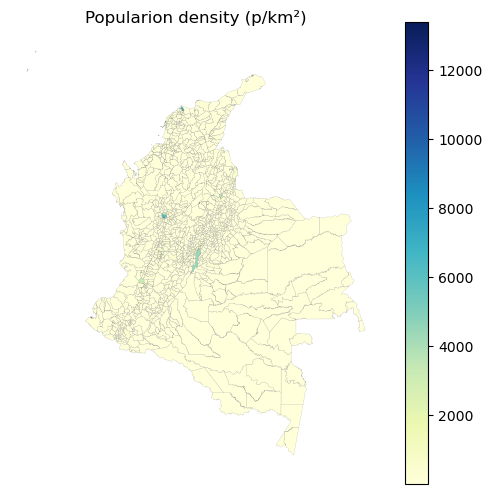

In [20]:
ax = muni.plot(column='pop_density_p_km2', cmap='YlGnBu', figsize=(6,6),
                     legend=True, edgecolor='grey', linewidth=0.1)
ax.set_title('Popularion density (p/km²)')
ax.set_axis_off()
plt.show()

### 4.  Spatial predicates  

We can test spatial relationships such as *contains* and *intersects*.  
The cell below creates a Shapely `Point` for Bolívar Square (Bogotá) in EPSG 4326, reprojects it to EPSG 3116, and finds the municipality that **contains** it.

In [132]:
from shapely.geometry import Point
bolivar = gpd.GeoSeries(
    [Point(-74.0760, 4.5981)], crs=4326).to_crs(3116)

mask = muni.contains(bolivar.iloc[0])
muni.loc[mask, ['MPIO_CNMBR', 'MPIO_CDPMP']]

,MPIO_CNMBR,MPIO_CDPMP
908,"BOGOTÁ, D.C.",11001


### 4.1.  Buffering & intersection  

The next cell builds a **10 km buffer** around Bolívar Square and selects municipalities that intersect that buffer, then plots the result.

- **`.buffer(10_000)`**: Creates a buffer zone of 10,000 metres (10 km) around each geometry in the `bolivar` GeoDataFrame. This results in a new geometry representing the area within 10 km of `bolivar`.

- **`.union_all()`**: Merges all geometries in the buffer into a single, unified geometry. This is necessary to ensure that spatial operations are applied to the entire buffer area as one object.

- **`muni.intersects(...)`**: Performs a spatial comparison between each municipality in `muni` and the unified buffer. Returns `True` if the geometries touch or overlap, and `False` otherwise.

- **`muni[...]`**: This is a filtering operation. Only those rows in `muni` where the `.intersects()` condition is `True` are selected and stored in `sel`.

- **`.plot(...)`**: Visualises the selected municipalities using light coral fill and black outlines. The buffer boundary is then overlaid using a navy colour for visual distinction.

- **`gpd.GeoSeries(...).boundary`**: Converts the buffer geometry to a GeoSeries and extracts its boundary (outline only) for plotting purposes.

- **`ax.set_axis_off()`**: Removes the axis from the plot to create a cleaner map visual.

- **`plt.show()`**: Displays the final plot.

This analysis allows us to visualise which municipalities fall within a certain distance of the target region (`bolivar`) — a common GIS task when performing proximity analysis.


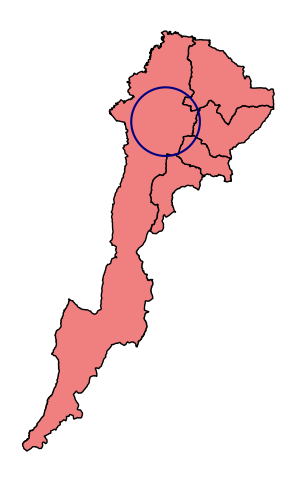

In [38]:
buffer_10km = bolivar.buffer(10_000)  # metres
sel = muni[muni.intersects(buffer_10km.union_all())]

ax = sel.plot(facecolor='lightcoral', edgecolor='black', figsize=(6,6))
gpd.GeoSeries(buffer_10km).boundary.plot(ax=ax, color='navy')
ax.set_axis_off()
plt.show()


### 4.2.  Overlay operations  

`geopandas.overlay()` performs geometric set operations.  

In the next cell (**`gpd.overlay(sel, …, how='intersection')`**)
   * `sel` is the subset of municipalities that intersect the 10 km buffer around Bolívar Square.  
   * We build a one-column GeoDataFrame from `buffer_10km` and ask GeoPandas to compute the *intersection*.  
   * The output `clipped` contains **only the portions of those municipalities lying inside the buffer**—all other parts are removed.

The you plot the result 
   * `edgecolor='darkgreen', facecolor='none'` draws hollow polygons with dark-green borders, helping you see the clipped shapes without obscuring any background.  
   * `figsize=(5, 5)` keeps the graphic compact.  
   * `plt.show()` displays the figure.

> This pattern is widely used for masking layers to a study area: you keep just the geometry relevant to your analysis while preserving all attribute columns.


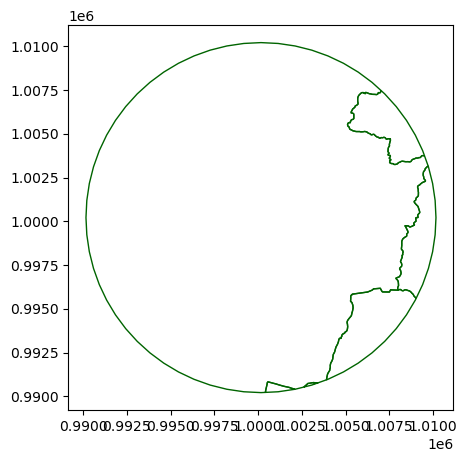

In [42]:
clipped = gpd.overlay(sel, gpd.GeoDataFrame(geometry=buffer_10km),
                        how='intersection')
clipped.plot(edgecolor='darkgreen', facecolor='none', figsize=(5,5))
plt.show()

### 4.3  Dissolving municipalities into departments  

Aggregating multiple geometries with `.dissolve()` produces multi‑polygon departments and summarises numeric attributes. 
The following cell rolls up the municipal layer to the **department** level:

* **`muni.dissolve(by='DPTO_CCDGO', …)`**  
  Groups polygons by the two-digit department code `DPTO_CCDGO` and **fuses** them into larger multi-polygons.
* **`aggfunc={'area_km2': 'sum', 'STP27_PERS': 'sum'}`**  
  Sums municipal area and population while dissolving, producing department-wide totals.
* **Population density** – we then derive `pop_density` by dividing department population by department area.

The returned GeoDataFrame `dptos` therefore contains **one row per department** with fresh attributes ready for mapping or further analysis.


In [45]:
dptos = muni.dissolve(
    by='DPTO_CCDGO',
    aggfunc={'area_km2': 'sum', 'STP27_PERS': 'sum'}
)
dptos['pop_density'] = dptos['STP27_PERS'] / dptos['area_km2']
dptos

,geometry,area_km2,STP27_PERS,pop_density
DPTO_CCDGO,,,,
05,"POLYGON ((8.76e+05 1.1e+06, 8.76e+05 1.1e+06, ...",62804.708984,5974788.0,95.132803
08,"POLYGON ((9.13e+05 1.64e+06, 9.13e+05 1.64e+06...",3315.752105,2342265.0,706.405342
11,"POLYGON ((1e+06 1.03e+06, 1e+06 1.03e+06, 1e+0...",1622.852605,7181469.0,4425.213343
13,"MULTIPOLYGON (((1.02e+06 1.31e+06, 1.02e+06 1....",26719.196397,1909460.0,71.463976
15,"POLYGON ((1.12e+06 1.04e+06, 1.12e+06 1.04e+06...",23138.048132,1135698.0,49.083570
17,"POLYGON ((8.61e+05 1.05e+06, 8.61e+05 1.05e+06...",7425.221672,923472.0,124.369620
18,"POLYGON ((1.15e+06 6.2e+05, 1.15e+06 6.2e+05, ...",90103.008160,359602.0,3.991010
19,"POLYGON ((7.67e+05 6.67e+05, 7.67e+05 6.67e+05...",31242.914795,1243503.0,39.801120
20,"POLYGON ((1.09e+06 1.38e+06, 1.09e+06 1.38e+06...",22562.344407,1098577.0,48.690729


#### Now it’s your turn #2 – Spatial data exercises  

1. Select and map **three** municipalities whose centroid lies west of 75° W longitude.  
2. Compute the *perimeter : area* ratio for every municipality and identify the most compact one.  
3. Draw a 10 km buffer around a municipality of your choice and highlight intersecting neighbours.
4. “Calculate and map the percentage of dwellings with internet


## 5  Attribute operations  
(If yo uwant to go further check **[This LINK](https://py.geocompx.org/02-attribute-operations.html)**)  
All 80 census variables are numeric counts, so they behave like ordinary pandas columns: you can add, divide, group, and classify them. See the manual for categorical meanings.


## 5.1  Column selection and boolean indexing  

The cell below keeps only selected columns and filters municipalities larger than 1 000 km².

In [49]:
core = muni[['DPTO_CCDGO', 'MPIO_CNMBR', 'area_km2']]
large = core[core.area_km2 > 1000].sort_values('area_km2', ascending=False)
large.head()

,DPTO_CCDGO,MPIO_CNMBR,area_km2
188,99,CUMARIBO,65597.212445
12,18,SOLANO,42312.783610
187,99,LA PRIMAVERA,18362.896666
11,18,SAN VICENTE DEL CAGUÁN,17464.634368
937,50,PUERTO GAITÁN,17250.083167


Show municipalities where < 30 % of dwellings have internet.

In [51]:
poor_net = muni[
    (muni['STP19_INT1'] / muni['STVIVIENDA']) < 0.3
][['MPIO_CNMBR', 'DPTO_CCDGO']]
poor_net.head()


,MPIO_CNMBR,DPTO_CCDGO
0,FLORENCIA,18
1,ALBANIA,18
2,BELÉN DE LOS ANDAQUÍES,18
3,EL DONCELLO,18
4,EL PAUJÍL,18


## 5.2  Creating new attributes  

We next classify municipal area into quartiles using `pd.qcut()`. Quantile classification is a quick way to create balanced size classes:

* **`pd.qcut(muni.area_km2, 4, labels=['Q1','Q2','Q3','Q4'])`**  
  Splits the `area_km2` distribution into four equal-frequency bins (quartiles) and labels them Q1–Q4.
* **`muni['area_class'].value_counts()`**  
  Shows how many municipalities fall into each quartile—useful for sanity-checking the split.

In [53]:
muni['area_class'] = pd.qcut(muni.area_km2, 4,
                             labels=['Q1','Q2','Q3','Q4'])
muni['area_class'].value_counts()

area_class
Q1    281
Q4    281
Q2    280
Q3    280
Name: count, dtype: int64

## 5.3  Grouping and summarising  


To discover which departments cover the largest territory we:

1. **Group by `DPTO_CCDGO`** – one record per department.
2. **Sum `area_km2`** – aggregate municipal areas.
3. **Sort descending** – most extensive departments first.
4. **Display the top five** – quick headline figures.


In [55]:
area_by_dpto = muni.groupby('DPTO_CCDGO')['area_km2'].sum()                      .sort_values(ascending=False)
area_by_dpto.head()

DPTO_CCDGO
91    109497.053810
99    100063.370746
18     90103.008160
50     85527.289734
94     71289.354694
Name: area_km2, dtype: float64

Computes the departmental share of households in ethnic territories.

In [57]:
ethnic_share = (
    muni.groupby('DPTO_CCDGO')['STP3_1_SI'].sum()
    / muni.groupby('DPTO_CCDGO')['STCTNENCUE'].sum()
    * 100
)
ethnic_share.sort_values(ascending=False).head()


DPTO_CCDGO
97    54.095904
27    34.801234
94    28.141512
44    27.811409
99    27.573751
dtype: float64

## 5.4  Joining a non‑spatial table  

We load the agricultural CSV, rename the municipality code column, and perform a **left join** onto the GeoDataFrame. This enriches the spatial layer with production information.


| Step | Action |
|------|--------|
 **Zero-pad codes to 5 digits** | Convert both key columns (`MPIO` and `MPIO_CDPMP`) to string type using `astype(str)`, then apply `.zfill(5)` to ensure each code has exactly five digits (e.g. `05266` instead of `5266`). This standardisation is critical for successful joins, as leading zeros are otherwise lost in numeric formats. |
| **Merge** | Use `muni.merge(...)` with `how='left'` to preserve all rows in the `muni` spatial dataset, even if no matching EVA record exists. The parameters `left_on='MPIO_CDPMP'` and `right_on='MPIO'` specify the respective join keys. |
| **Diagnostics** | Setting `indicator=True` adds a new column called `_merge`, which indicates whether each row matched on both sides (`both`), only in the left (`left_only`), or only in the right (`right_only`). The `validate='one_to_many'` argument checks that each municipality in `muni` links to at most one match in `eva`, helping catch unexpected duplicates. |
| **Collision control** | The `suffixes=('', '_eva')` argument avoids unintentional overwriting of columns with identical names in both datasets by appending `_eva` to the conflicting column names from the EVA table. |

After the join, `muni_eva` carries all original municipal attributes **plus** EVA variables, ready for mapping yields, harvested area, or production volumes.


In [59]:
eva = pd.read_csv(csv_path, encoding='latin1')

#TRy also this one
eva = pd.read_csv(csv_path, encoding='utf-8')

eva = eva.rename(columns={'CÓD. MUN.': 'MPIO'})
print(eva.head())
eva['MPIO'] = eva['MPIO'].astype(str).str.zfill(5)
muni['MPIO_CDPMP'] = muni['MPIO_CDPMP'].astype(str).str.zfill(5)

muni_eva = muni.merge(
    eva,
    how='left',                 # left = muni
    left_on='MPIO_CDPMP',       # key in en muni
    right_on='MPIO',            # key in eva
    indicator=True,             # create  column _merge
    validate='one_to_many',      # or 'one_to_many' check all the possibilities
    suffixes=('', '_eva')       # evita colisiones de nombre
)
print(muni_eva['_merge'].value_counts())
print(muni_eva.columns.tolist())

   CÓD. \nDEP.        DEPARTAMENTO   MPIO   MUNICIPIO GRUPO \nDE CULTIVO  \
0           15              BOYACA  15114    BUSBANZA         HORTALIZAS   
1           25        CUNDINAMARCA  25754      SOACHA         HORTALIZAS   
2           25        CUNDINAMARCA  25214        COTA         HORTALIZAS   
3           54  NORTE DE SANTANDER  54405  LOS PATIOS         HORTALIZAS   
4           54  NORTE DE SANTANDER  54518    PAMPLONA         HORTALIZAS   

  SUBGRUPO \nDE CULTIVO CULTIVO DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO  \
0                ACELGA  ACELGA                                        ACELGA   
1                ACELGA  ACELGA                                        ACELGA   
2                ACELGA  ACELGA                                        ACELGA   
3                ACELGA  ACELGA                                        ACELGA   
4                ACELGA  ACELGA                                        ACELGA   

    AÑO PERIODO  Área Sembrada\n(ha)  Área Cosechada\n(h

The next cell derives **rice yield** (t ha⁻¹) and maps it using a quantile scheme and the `PuRd` colour map. 
What happens if you use the column PERIODO instead of AÑO?

Rows kept: 343
                MPIO_CNMBR CULTIVO     AÑO
29               FLORENCIA   ARROZ  2018.0
643              EL PAUJÍL   ARROZ  2018.0
758           LA MONTAÑITA   ARROZ  2018.0
958                  MILÁN   ARROZ  2018.0
1466  CARTAGENA DEL CHAIRÁ   ARROZ  2018.0


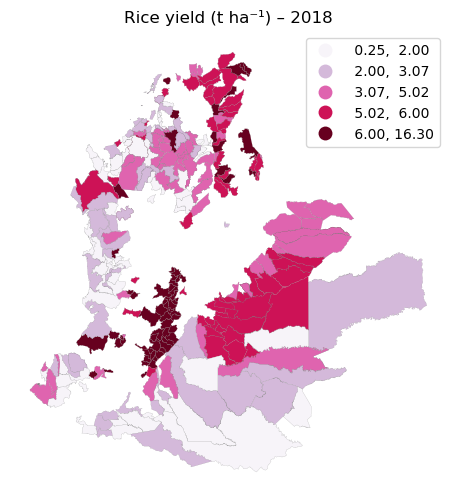

In [74]:
# --- Parameters -------------------------------------------------------------
selected_year = 2018          # <- choose the year you want to visualise
crop_name     = 'ARROZ'       # <- crop label exactly as it appears in EVA

# --- Subset for crop and year ----------------------------------------------
# 1. Keep rows matching the chosen crop
# 2. Keep rows for the chosen year
rice = (
    muni_eva
    .query("CULTIVO == @crop_name and AÑO == @selected_year")  # edit column name if needed
    .copy()
)

# Sanity-check: does the subset look right?
print(f"Rows kept: {len(rice):,}")
print(rice[['MPIO_CNMBR', 'CULTIVO', 'AÑO']].head())

# --- Calculate yield --------------------------------------------------------
rice['yield_t_ha'] = (
    rice['Producción\n(t)'] / rice['Área Sembrada\n(ha)']
)

# Drop any rows with missing yield
rice_map = rice.dropna(subset=['yield_t_ha'])

# --- Plot -------------------------------------------------------------------
ax = rice_map.plot(
    column='yield_t_ha',
    scheme='Quantiles', k=5,
    cmap='PuRd', legend=True,
    figsize=(6, 6),
    edgecolor='grey', linewidth=0.1
)
ax.set_title(f'Rice yield (t ha⁻¹) – {selected_year}')
ax.set_axis_off()
plt.show()


#### Now it’s your turn #3 – Attribute drills  

1. Create a bar chart of the **top‑10** municipalities by *maize* production.  
2. Map coffee yield and describe spatial trends you observe.  
3. Calculate the mean municipal area per *ZONA* category.
4. Map the proportion of dwellings connected to gas: STP19_GAS1 / STVIVIENDA.
5. Compute the sex ratio (STP32_1_SE / STP32_2_SE) for every municipality and discuss spatial patterns.


---

## 6.  Visualisation best practice  

Choose an equal‑area CRS, add clear legends, north arrows, and cite data sources.  
The next cell reprojects the rice yield map to **Web Mercator (EPSG 3857)**, adds a basemap, and annotates the source line.

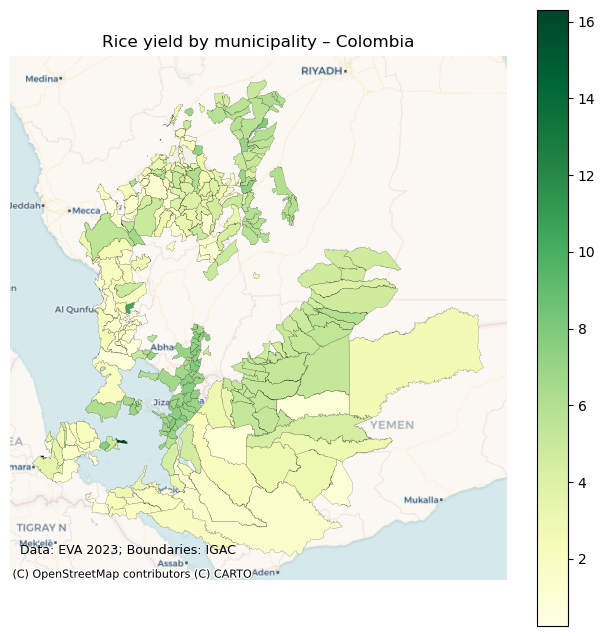

In [146]:
ax = rice_map.to_crs(9377).plot(column='yield_t_ha', cmap='YlGn',
                     figsize=(8,8), edgecolor='black', linewidth=0.1, legend=True)
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)
ax.set_title('Rice yield by municipality – Colombia')
ax.annotate('Data: EVA 2023; Boundaries: IGAC', xy=(0.02, 0.05),
            xycoords='axes fraction', fontsize=9)
ax.set_axis_off()
plt.show()

#### Now it’s your turn #4 – Cartography challenge  

* Re‑project to the CRS 4326.  
* Add grey department boundaries on top.  
* Compose a concise caption in British English that explains what the map shows.  


## 📚 7. project – Bringing it all together  
*(revised to reflect municipal-level production totals)*

### Project title  
**“Are Colombia’s meteorological stations well-placed to support its main crop-producing municipalities?”**

### Context  
The EVA dataset provides **municipal totals** of sown area, production and yield—there is **no field-boundary geometry**. Therefore every agricultural metric is attached to the municipality polygon (or its centroid). Your analysis must respect that spatial resolution.

### Objective  
Evaluate how effectively the national meteorological-station network covers the municipalities that account for the bulk of crop production.

### Data  
* `municipios_colombia.shp` – municipal boundaries, EPSG 3116  
* `Evaluaciones_Agropecuarias_Municipales_EVA.csv` – yearly production totals per municipality  
* `Catalogo_Estaciones_IDEAM.csv` – latitude/longitude of meteorological stations (convert to EPSG 3116)



### Tasks  

| # | Task | Key skills revisited |
|---|------|----------------------|
| 1 | **Load & harmonise**  <br>• Read all three files.  <br>• Zero-pad municipal codes and ensure all geometries are in EPSG 3116. | File I/O, CRS handling |
| 2 | **Crop–year focus**  <br>• Choose *one* crop (e.g. rice) and *one* recent year.  <br>• Compute municipal **production**, **sown area**, **yield (t ha⁻¹)**. | Attribute join, filtering, derived variables |
| 3 | **Top-quartile producers**  <br>• Flag municipalities in the **upper quartile of production**.  <br>• Produce both a map and a table (top 20) of those municipalities. | Quantile classification, choropleths, tables |
| 4 | **Station counts**  <br>• Convert the station CSV to a `GeoDataFrame`.  <br>• **Spatial join** each station to its department (`gpd.sjoin`).  <br>• Generate a table: *number of stations per department*.  <br>• Create:  <br> a) a choropleth map of station counts by department,  <br> b) a horizontal bar chart of the same counts (descending order). | Point–polygon spatial join, aggregation, mapping, tabular visualisation |
| 5 | **Production vs coverage**  <br>• Dissolve municipalities to departments (summing crop production).  <br>• Join the station-count table to this dissolved layer.  <br>• Produce a scatter plot of *departmental production* vs *station count*; label the four extremal cases (high-production/low-coverage, etc.). | Dissolve with custom `aggfunc`, joins, scatter plots |
| 6 | **Short commentary** (max 120 words)  <br>Briefly comment on any mismatch between production volume and station coverage; suggest two departments that might benefit from additional stations. | Concise interpretation |

### Deliverables  

1. A single, well-structured notebook (`.ipynb`) containing code, markdown explanations, a minimum of **two maps** (Tasks 3 & 4) and **two charts** (bar + scatter).  
2. Any image exports stored in a `/figures` folder.

### Assessment rubric (18 points)  

### Marking rubric – Capstone project

| Criterion (max 10 pts each) | Excellent (10) | Good (8) | Satisfactory (6) | Needs improvement (0-5) |
|----------------------------|---------------|----------|------------------|-------------------------|
| **1. Data preparation & CRS**<br>*Task 1* | All three datasets loaded correctly; municipal codes zero-padded; every layer re-projected to EPSG 3116 and the CRS explicitly documented. | Minor slip (e.g. one CRS printout missing) but data still correct. | Significant omissions (e.g. no CRS check) yet analysis still runs. | Wrong CRS or unpadded codes cause spatial mismatch / results invalid. |
| **2. Crop–year analysis**<br>*Task 2* | Production, sown area and yield calculated flawlessly for chosen crop-year; clear explanation of formulae. | One calculation or explanation unclear but outcomes largely correct. | Calculations patchy or inconsistently labelled. | Crop–year subset or yield calculation incorrect / absent. |
| **3. Spatial joins & aggregation**<br>*Tasks 3–5* | Station-to-department join, department dissolve and station counts executed with correct predicates and `aggfunc`; outputs fully validated (row counts, null checks). | Logical joins/aggregations but validation limited. | Joins partly correct (e.g. wrong predicate) yet results broadly plausible. | Joins/aggregations flawed or missing → results misleading. |
| **4. Visualisation quality**<br>*Maps × 2, bar, scatter* | Maps use appropriate colour ramps, legends, titles; bar & scatter charts clearly labelled; figures exported to `/figures`. | Visuals intelligible but minor cosmetic issues (legend size, axis units). | Visuals produced but cluttered or lacking legends/titles. | Required visuals missing or unreadable. |
| **5. Code structure & documentation** | Notebook cleanly sectioned; functions or reusable blocks minimise repetition (DRY); markdown explains every step. | Mostly well-structured; a few redundant code blocks or sparse comments. | Long repetitive cells; key decisions undocumented. | Disorganised, little or no explanation, hard to follow. |

**Total: 50 points**



In [107]:
# You r script here 

